## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet121 Model](#model)  ##
## [5. Training and Fine Tuning](#train) ##
## [6. Visualizing Results](#vis) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [32]:
train_dir = "/content/drive/MyDrive/Human Emotion Classification/train"
test_dir = "/content/drive/MyDrive/Human Emotion Classification/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.001
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Angry', 'Happy','Sad']
CLASS_LABELS_EMOJIS = ["👿","😊", "😔" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [33]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rotation_range=20,
                                   rescale=1./255,
                                   validation_split=0.3,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    subset="training",
                                                    seed=42
                                                   )

validation_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         color_mode="rgb",
                                                         class_mode="categorical",
                                                         subset="validation",
                                                         seed=42
                                                        )

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=False,
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   seed=42
                                                  )

Found 1595 images belonging to 3 classes.
Found 683 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


## Images with different emotions

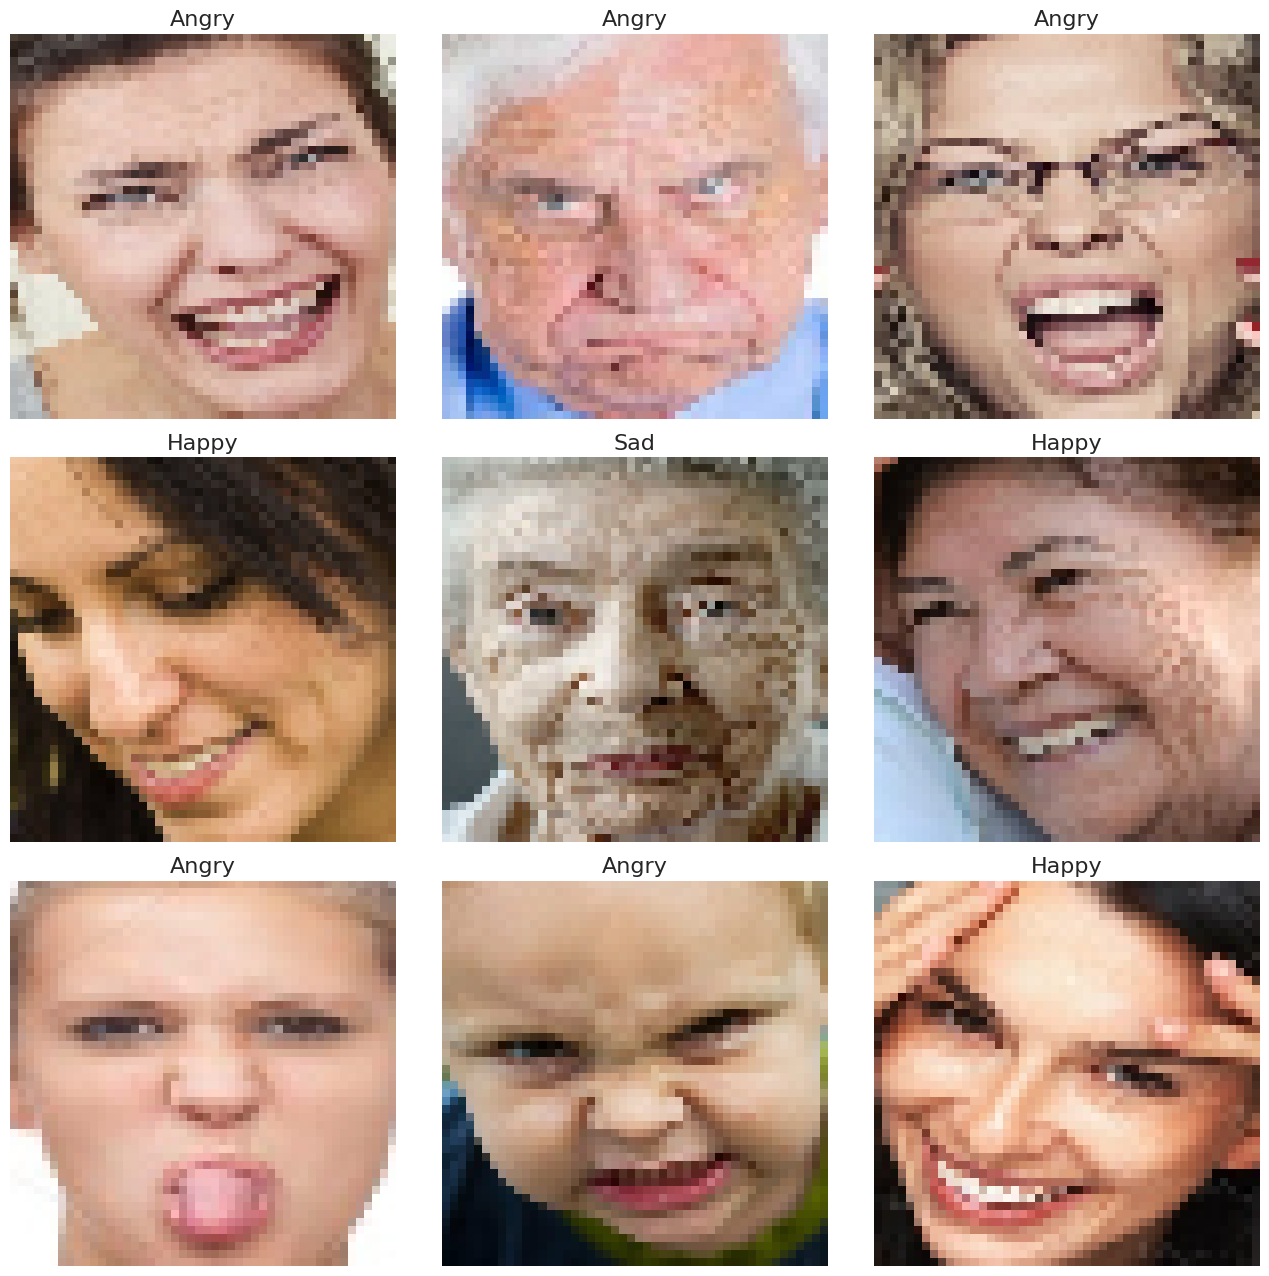

In [34]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 42
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [35]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> VGG16 Transfer Learning  </center>

In [36]:
import tensorflow as tf

def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                          include_top=False,
                                                          weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## Summary of model

In [37]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0   

<a id="train"></a>
# <center> Training and Fine-Tuning </center>

## Training model with freezed layers of DenseNer169

In [38]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
50/50 [==============================] - 104s 2s/step - loss: 8.2561 - accuracy: 0.2834 - val_loss: 7.7281 - val_accuracy: 0.3734
Epoch 2/30
50/50 [==============================] - 79s 2s/step - loss: 8.0214 - accuracy: 0.2934 - val_loss: 8.1567 - val_accuracy: 0.3734
Epoch 3/30
50/50 [==============================] - 78s 2s/step - loss: 7.8633 - accuracy: 0.3561 - val_loss: 9.0478 - val_accuracy: 0.3734
Epoch 4/30
50/50 [==============================] - 79s 2s/step - loss: 7.8055 - accuracy: 0.3618 - val_loss: 8.4550 - val_accuracy: 0.3734
Epoch 4: early stopping


## Fine Tuning

In [39]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
50/50 [==============================] - 105s 2s/step - loss: 7.9577 - accuracy: 0.3292 - val_loss: 8.2993 - val_accuracy: 0.3734
Epoch 2/20
50/50 [==============================] - 77s 2s/step - loss: 7.8889 - accuracy: 0.3241 - val_loss: 8.9893 - val_accuracy: 0.3734
Epoch 3/20
50/50 [==============================] - 80s 2s/step - loss: 7.8197 - accuracy: 0.3561 - val_loss: 7.8894 - val_accuracy: 0.3734
Epoch 4/20
50/50 [==============================] - 77s 2s/step - loss: 7.8155 - accuracy: 0.3429 - val_loss: 9.2902 - val_accuracy: 0.3734
Epoch 5/20
50/50 [==============================] - 78s 2s/step - loss: 7.7417 - accuracy: 0.3743 - val_loss: 10.0737 - val_accuracy: 0.3734
Epoch 6/20
50/50 [==============================] - 80s 2s/step - loss: 7.7283 - accuracy: 0.3843 - val_loss: 7.6531 - val_accuracy: 0.3543
Epoch 7/20
50/50 [==============================] - 81s 2s/step - loss: 7.7304 - accuracy: 0.3799 - val_loss: 7.8481 - val_accuracy: 0.2972
Epoch 8/20
50/50 [

## Training plots

In [40]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [41]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center>

## Model Evaluation

In [42]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

18/18 [==============================] - 8s 257ms/step


## Confusion Matrix

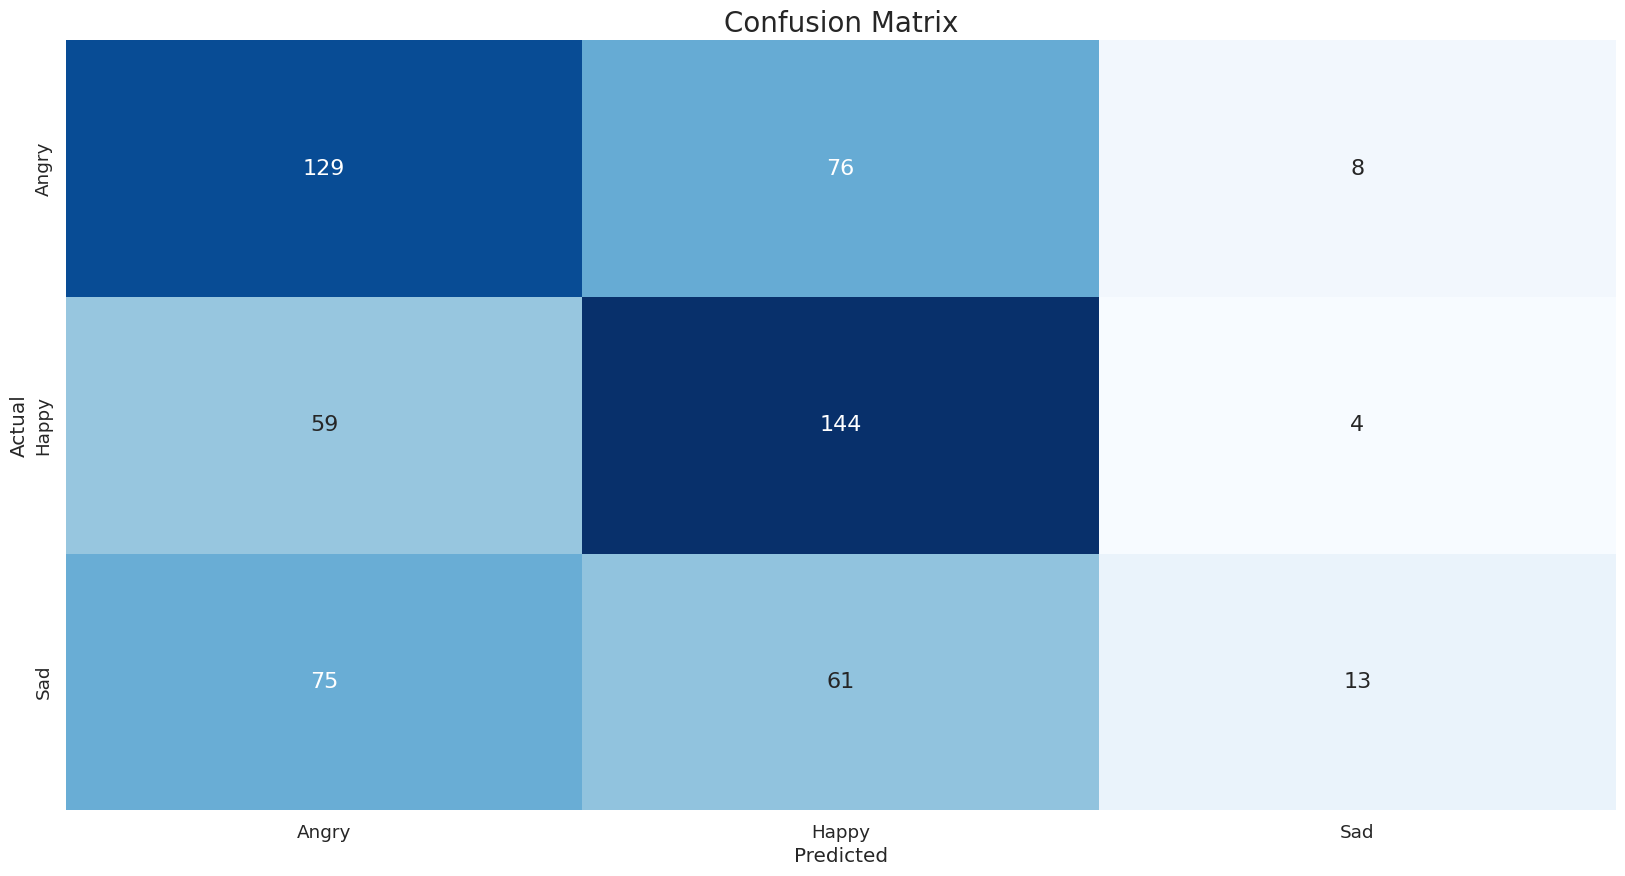

In [43]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report

In [44]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.49      0.61      0.54       213
           1       0.51      0.70      0.59       207
           2       0.52      0.09      0.15       149

    accuracy                           0.50       569
   macro avg       0.51      0.46      0.43       569
weighted avg       0.51      0.50      0.46       569



## Multiclass AUC Curve

ROC AUC score: 0.675400218062089


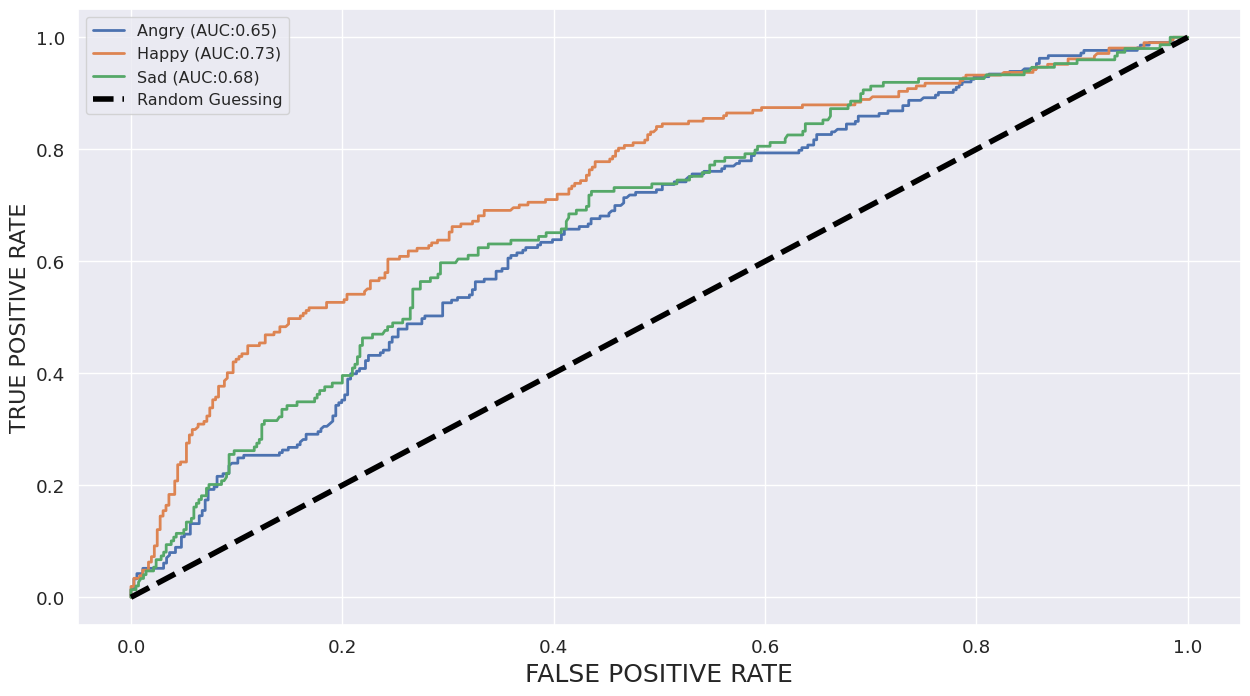

In [45]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [46]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.6872453417297004


## Predict

In [47]:
# import numpy as np
# from google.colab import files
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# %matplotlib inline

# uploaded = files.upload()

# for fn in uploaded.keys():

#   # predicting images
#   path = fn
#   img = image.load_img(path, target_size=(48,48))

#   imgplot = plt.imshow(img)
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   images = np.vstack([x])

#   classes = model.predict(images, batch_size=30)
#   print(fn)
#   if classes[0, 0] == 1:
#     print('angry')
#   elif classes[0, 1] == 1:
#     print('happy')
#   elif classes[0, 2] == 1:
#     print('sad')